In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from matplotlib.dates import YearLocator, MonthLocator, DateFormatter
from pandas import DataFrame, Panel4D, read_hdf
from glob import glob
from datetime import datetime
import time
import matplotlib
import random
import gps
from IPython.display import Image
from pandas import DataFrame,Series
import CoordTransforms3 as CT


/home/greg/Documents/Summer Research/rinex files/mah62800.15o is a RINEX 2.11 file, 31649.899 kB.
38.31 seconds for _block2df
22.42 seconds for panel assignments
finished in 64.56 seconds


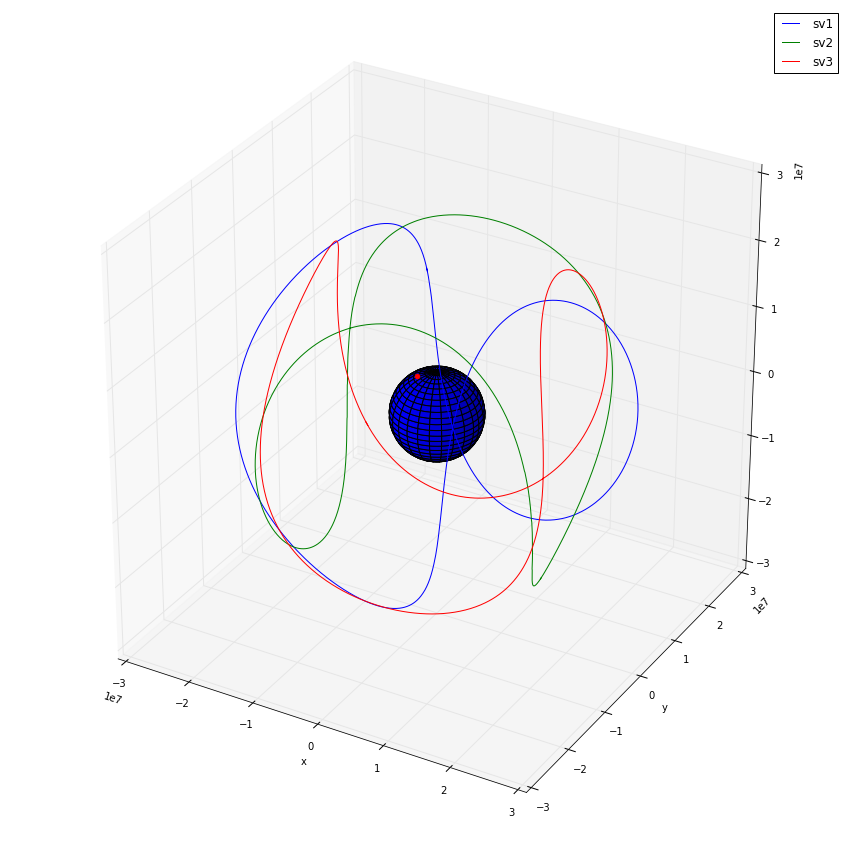

In [2]:
from mpl_toolkits.mplot3d import Axes3D
files = glob('/home/greg/Documents/Summer Research/rinex files/mah*')
head,data = gps.rinexobs(files[0],returnHead=True)
nav = gps.readRinexNav('./brdc2800.15n')
import datetime

base = datetime.datetime(2015,10,7,0)
arr = np.array([base + datetime.timedelta(minutes=i) for i in range(60*24)])


satpos1 = gps.getSatXYZ(nav,1,arr)
satpos2 = gps.getSatXYZ(nav,2,arr)
satpos3 = gps.getSatXYZ(nav,3,arr)

recpos=np.asarray(head['APPROX POSITION XYZ'])[:,None]

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
ax.set_aspect('equal')

u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
dist = np.linalg.norm(recpos)
x = dist * np.outer(np.cos(u), np.sin(v))
y = dist * np.outer(np.sin(u), np.sin(v))
z = dist * np.outer(np.ones(np.size(u)), np.cos(v))


ax.plot_surface(x,y,z,rstride=4,cstride=4,color='b',linewidth=1,alpha=1)
ax.plot(recpos[0],recpos[1],recpos[2],'r.',markersize=10)
ax.plot(satpos1[:,0],satpos1[:,1],satpos1[:,2],label='sv1')
ax.plot(satpos2[:,0],satpos2[:,1],satpos2[:,2],label='sv2')
ax.plot(satpos3[:,0],satpos3[:,1],satpos3[:,2],label='sv3')

plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid()
plt.show()


This is just a cool plot of satellite position to show that my positioning functions work, below is my replica
of Bill Rideout's plot taking into account satellite bias and finding receiver bias using the minimum scalloping 
method. I still need to figure out least squares bias estimation. For now, this plot looks pretty good.

/home/greg/Documents/Summer Research/rinex files/mah62800.15o is a RINEX 2.11 file, 31649.899 kB.
37.01 seconds for _block2df
21.48 seconds for panel assignments
finished in 62.07 seconds
Receiver Bias:
1x 2x 3x 5x 6x 7 8x 9 11x 13 15x 16x 17x 18x 19x 20x 22x 23 24x 26x 27x 28 30 31x 32x 
/home/greg/Documents/Summer Research/rinex files/mah32800.15o is a RINEX 2.11 file, 38072.718 kB.
35.83 seconds for _block2df
19.59 seconds for panel assignments
finished in 58.81 seconds
Receiver Bias:
1x 2x 3x 4x 5x 6x 7 8x 9 11x 13 15x 16x 17x 18x 19x 20x 21x 22x 23 24x 25x 26x 27x 28 29x 30 31x 32x 
/home/greg/Documents/Summer Research/rinex files/mah52800.15o is a RINEX 2.11 file, 35699.333 kB.
36.50 seconds for _block2df
19.76 seconds for panel assignments
finished in 59.68 seconds
Receiver Bias:
1x 2x 3x 4x 5x 6x 7 8x 9 11x 13 15x 16x 17x 18x 19x 20x 23 24x 26x 27x 28 29x 30 31x 32x 333538
/home/greg/Documents/Summer Research/rinex files/mah42800.15o is a RINEX 2.11 file, 37584.842 kB.
35.97 se

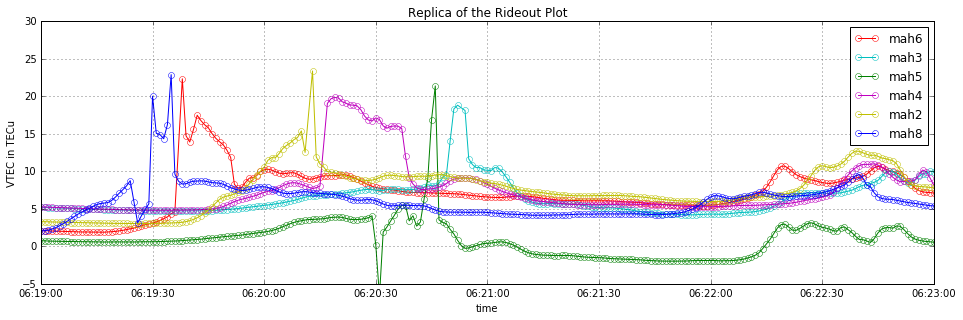

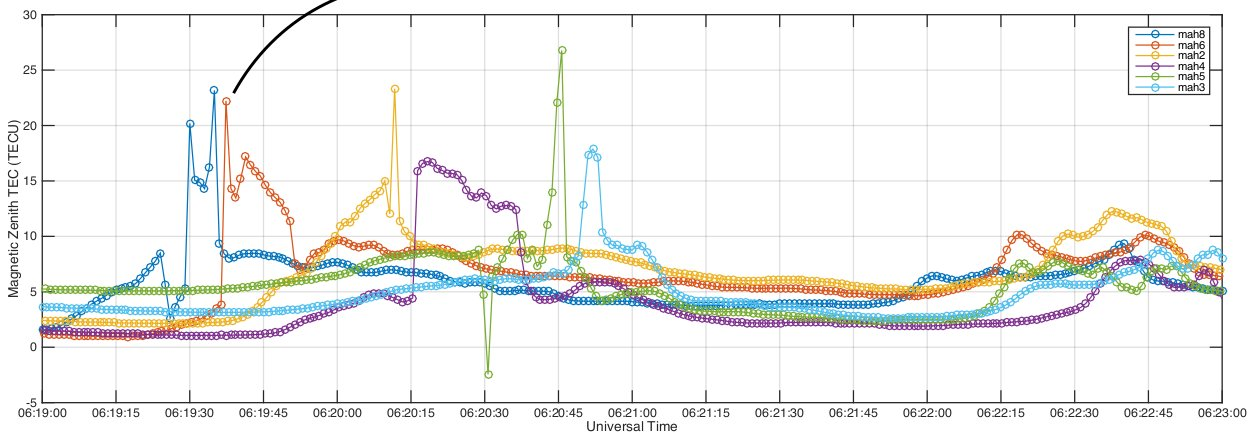

In [3]:
########################
sv = 23
########################

#set up plot
plt.figure(figsize=(16,16))
fmt = DateFormatter('%H:%M:%S')
plt.subplot(311).xaxis.set_major_formatter(fmt)
colors = ['b','y','m','g','c','r']

#display date ranges
start = datetime(2015,10,7,6,19,0)
end = datetime(2015,10,7,6,23,0)

#files
files = glob("/home/greg/Documents/Summer Research/rinex files/mah*")

#navigation rinex, satellite bias
nav = gps.readRinexNav('./brdc2800.15n')
svBiasObj = gps.satelliteBias('jplg2800.15i','P1C11510.DCB',None)
satbias = svBiasObj.dict[(sv,1)]

for file in files:   #LOTS OF REPEATED CALCULATION HERE, NEED TO DO EVERYTHING ONLY ONCE
    site = file.split('/')[-1][:4]
    if int(site[3]) in [2,3,4,5,6,8]:
        #get data, sat position, mapping function
        head,data = gps.rinexobs(file,returnHead=True)
        satpos = gps.getSatXYZ(nav,sv,data.labels)
        recpos = np.asarray(head['APPROX POSITION XYZ'],float)[:,None]
        el = Series(gps.getEl(satpos,recpos),index=data.labels)
        z = gps.getZ(el)
        #calculate receiver bias
        print('Receiver Bias:')
        recbias = gps.minScalBias(head,data,nav,svBiasObj) 
        print()
        #calculate tec
        ranges = gps.getRanges(data,sv)
        teclist = []
        timelist = []
        for drange in ranges:
            tec,err = gps.getTec(data,sv,drange)
            tec-=satbias
            teclist.append(tec)
            timelist.append(tec.index)
        
        #plot tec
        if len(teclist)>0 and len(timelist)>0:  
            color = colors.pop()
            stec = Series(np.hstack((p for p in teclist)),index=np.hstack((t for t in timelist)))
            stec-=recbias
            vtec = stec/(z[stec.index])
            plt.plot(vtec,'o-',c=color,label=site,fillstyle='none')
            
#adjust plot
plt.xlim([start,end])
plt.ylim([-5,30])
plt.legend()
plt.grid()
plt.xlabel('time')
plt.ylabel('VTEC in TECu')
plt.title('Replica of the Rideout Plot')
plt.show()

Image("gradient.jpg")


In [6]:
####################
#LEAST SQUARES
####################


bias

9.6166666666666654